In [1]:
#####Bayesian Rank Decomposition#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z
    return z_id

In [3]:
####データの発生####
##データの設定
k = 10
select = 10
hh = 5000
member = 250
Lambda = np.random.gamma(30, 1/0.3, hh)
pt = np.random.poisson(Lambda, hh); pt[pt > member] = member
hhpt = np.sum(pt)
max_pt = np.max(pt)
m_vec = np.repeat(1, member)

In [4]:
##idとインデックスの設定
#idの設定
user_id = np.repeat(np.arange(hh), pt)
rank_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))
rank_pt = np.max(pt)

#インデックスの設定
user_list = [i for i in range(hh)]
rank_list = [j for j in range(max_pt)]
rank_n = np.repeat(0, max_pt)
for i in range(hh):
    user_list[i] = np.array(np.where(user_id==i)[0], dtype="int")
for j in range(max_pt):
    rank_list[j] = np.array(np.where(rank_id==j)[0], dtype="int")
    rank_n[j] = rank_list[j].shape[0] 

In [5]:
##応答変数を生成
#ユーザーの説明変数を生成
k1 = 4; k2 = 3; k3 = 4
u1 = np.array(np.random.random(hh*k1)).reshape((hh, k1))
u2 = np.zeros((hh, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    u2[:, j] = np.random.binomial(1, prob, hh)
u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hh)
u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
u = np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1)
column = u.shape[1]

#階層モデルのパラメータ
alpha_u = np.random.normal(0, 0.4, column*k).reshape(column, k)
alpha_v = np.repeat(0.0, k)
Cov_u = np.diag(np.repeat(0.2, k))
Cov_v = np.diag(np.repeat(0.6, k))
alphat_u = alpha_u.copy(); alphat_v = alpha_v
Covt_u = Cov_u.copy(); Covt_v = Cov_v.copy()

#モデルパラメータを生成
beta = np.random.normal(0.5, 1.25, member-1)
theta_u = np.dot(u, alpha_u) + np.random.multivariate_normal(np.repeat(0, k), Cov_u, hh)
theta_v = np.vstack((np.random.multivariate_normal(alpha_v, Cov_v, member-1), np.repeat(0, k)))
betat = beta.copy(); thetat_u = theta_u.copy(); thetat_v = theta_v.copy()

#全パターンのロジットと応答確率を定義
logit = np.append(beta, 0) + np.dot(theta_u, theta_v.T)
logit_exp = np.exp(logit)
Prob = logit_exp / np.dot(logit_exp, m_vec)[:, np.newaxis]

#多項分布からランクを生成
Prob_rank = np.zeros((hhpt, member), dtype="float32")
y = np.zeros((hhpt, member), dtype="int8")
Z = np.ones((hhpt, member), dtype="int8")
for j in range(max_pt):
    if j==0:
        index = rank_list[j]
        Prob_rank[index, ] = Prob.copy()
        y[index, ] = np.array(rmnom(Prob_rank[index, ], rank_n[j], member, np.arange(rank_n[j]), 1)[1].todense(), dtype="int8")
    else:
        index = rank_list[j]
        Z[index, ] = (1-y[index-1, ]) * Z[index-1, ]
        logit_rank = Z[index, ] * np.exp(logit[user_id[index], ])
        Prob_rank[index, ] = logit_rank / np.dot(logit_rank, m_vec)[:, np.newaxis]
        y[index, ] = np.array(rmnom(Prob_rank[index, ], rank_n[j], member, np.arange(rank_n[j]), 1)[1].todense(), dtype="int8")

#応答変数をベクトルに変換
y_vec = y.reshape(-1)

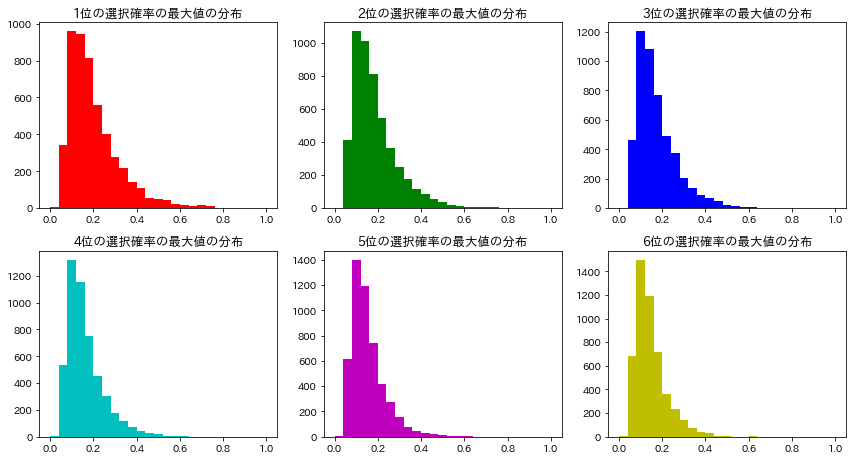

[2742 2271 1636  205 4169 1693 2455 3759  655  469 4056 1502  799  743
 4750  532 3054 2150 3320  363  521 3206  564 3533 2049 1514 3498 3974
 1000 3013  669 4581 2002 3477 3540 2056 2531 3925 2802 1599 3789 3236
 2102 2230 3775 1375  996 4009 1528 2677  564  979 1961 2829 1481  806
  191 3781  702 1425 2110 2500  337 3141  762 1496  409  245 2707 1127
 3986 2003 1679  593 2237 1595  882  431  429 2503 2844 1604 4175 4077
  511 2428  297  479 3553  890 2358 1526 3252   36 1583 2316 2983 2077
 2584 1487   75 1890 4214 4862 4909 2010 1854  291 3652  430 1666 3027
 3169 2882 3897 2257 3208 2358  678  301 1226 3040 1044  369 1098 1301
 1269 3599 2383 4853  678  906 2343 2108  313 3040 1178  674 1202 2293
 1136 1929 2505 3100 1760 4630 1129 2446 3546 1433 1076 1141 2933 3631
 1338  773  730  894  946 4337 3649   96 1420  771  199  178 4255 1370
 2121 2500 1426 2050  933  906 2444 2345 4511 1780  133 3700 2328  960
 1022 2090 2427 1720 2843 1816 1771 2621 2772  861 3865 4109  662 1255
 2729 

In [6]:
#生成したデータの集計と可視化
fig_range = np.append(np.array([0, 0, 0, 0, 0, 0]), np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])).reshape(2, 6)
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["1位の選択確率の最大値の分布", "2位の選択確率の最大値の分布", "3位の選択確率の最大値の分布",
         "4位の選択確率の最大値の分布", "5位の選択確率の最大値の分布", "6位の選択確率の最大値の分布"]
fig = plt.figure(figsize=(12.0, 6.5))
for j in range(len(legend)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(np.max(Prob_rank[rank_list[j], ], axis=1),  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

print(np.sum(y, axis=0))
print(np.round(np.sum(y, axis=0) / hhpt, 3))

In [7]:
####テストデータの生成####
##データの設定
shrink = 1.5
pt0 = np.random.poisson(Lambda/shrink, hh); pt[pt > member] = member
N0 = np.sum(pt0)
max_pt0 = np.max(pt0)

In [8]:
##idとインデックスの設定
#idの設定
user_id0 = np.repeat(np.arange(hh), pt0)
rank_id0 = np.array(list(itertools.chain(*[np.array(range(pt0[i]), dtype="int") for i in range(hh)])))
rank_pt0 = np.max(pt0)

#インデックスの設定
user_list0 = [i for i in range(hh)]
rank_list0 = [j for j in range(max_pt0)]
rank_n0 = np.repeat(0, max_pt0)
for i in range(hh):
    user_list0[i] = np.array(np.where(user_id0==i)[0], dtype="int")
for j in range(max_pt0):
    rank_list0[j] = np.array(np.where(rank_id0==j)[0], dtype="int")
    rank_n0[j] = rank_list0[j].shape[0] 

In [9]:
##応答変数の生成
#全パターンのロジットと応答確率を定義
logit0 = np.append(beta, 0) + np.dot(theta_u, theta_v.T)
logit_exp0 = np.exp(logit0)
Prob0 = logit_exp0 / np.dot(logit_exp0, m_vec)[:, np.newaxis]

#多項分布からランクを生成
Prob_rank0 = np.zeros((N0, member), dtype="float32")
y0 = np.zeros((N0, member), dtype="int8")
Z0 = np.ones((N0, member), dtype="int8")
for j in range(max_pt0):
    if j==0:
        index = rank_list0[j]
        Prob_rank0[index, ] = Prob0.copy()
        y0[index, ] = np.array(rmnom(Prob_rank0[index, ], rank_n0[j], member, np.arange(rank_n0[j]), 1)[1].todense(), dtype="int8")
    else:
        index = rank_list0[j]
        Z0[index, ] = (1-y0[index-1, ]) * Z0[index-1, ]
        logit_rank = Z0[index, ] * np.exp(logit[user_id0[index], ])
        Prob_rank0[index, ] = logit_rank / np.dot(logit_rank, m_vec)[:, np.newaxis]
        y0[index, ] = np.array(rmnom(Prob_rank0[index, ], rank_n0[j], member, np.arange(rank_n0[j]), 1)[1].todense(), dtype="int8")

In [10]:
#####マルコフ連鎖モンテカルロ法でBayesian Rank Decompositionを推定####
##HMCでパラメータを推定するための関数
#対数事後分布の和を計算する関数
def Posterior(y, Z, logit, theta, inv_Cov, user_id, n, k, m_vec, pattern1, pattern2):
    #ロジットの対数尤度
    logit_exp = Z * np.exp(logit)[user_id, ] 
    Prob = logit_exp / np.dot(logit_exp, m_vec)[:, np.newaxis]
    LLho = np.log(np.dot(y * Prob, m_vec))

    #多変量正規分布の対数事前分布
    er = theta - alpha_mu   #パラメータの誤差
    if pattern1==1:
        LLi_mvn = -1/2 * np.dot(np.dot(er, inv_Cov) * er, np.repeat(1, k))
    else:
        LLi_mvn = -1/2 * er * inv_Cov * er 

    #対数事後分布の和
    if pattern2==1:
        LL = np.repeat(0.0, n)
        for i in range(n):
            LL[i] = np.sum(LLho[index[i], ]) + LLi_mvn[i]
    else:
        LL = np.sum(LLho) + LLi_mvn
    return LL, LLho

In [11]:
#期待値パラメータの勾配を計算する関数
def dloglike(beta, alpha, inv_Cov, uv, y, Z, user_id, m_vec, member):
    #応答確率の定義
    logit = np.append(beta, 0) + uv
    logit_exp = Z * np.exp(logit)[user_id, ]
    Prob = logit_exp / np.dot(logit_exp, m_vec)[:, np.newaxis]

    #勾配ベクトルの和を定義
    er_y = y - Prob; er = theta - alpha  
    dlogit = np.sum(er_y[:, :member-1], axis=0)
    dmvn = -np.dot(inv_Cov, er.T).T
    return -(dlogit + dmvn)

#リープフロッグ法を解く関数
def leapfrog(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, alpha, inv_Cov, uv, y, Z, user_id, m_vec, member) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, alpha, inv_Cov, uv, y, Z, user_id, m_vec, member) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [12]:
#ユーザー特徴ベクトルの勾配を計算する関数
def dloglike_u(theta_u, theta_v, beta, alpha_u, inv_Cov_u, y, Z, u, user_id, user_list, hh, k, m_vec):
    #応答確率の定義
    logit = np.append(beta, 0) + np.dot(theta_u, theta_v.T)
    logit_exp = Z * np.exp(logit)[user_id, ]
    Prob = logit_exp / np.dot(logit_exp, m_vec)[:, np.newaxis]

    #微分関数の設定
    er_y = y - Prob; er = theta_u - np.dot(u, alpha_u) 
    dlogit = np.dot(er_y, theta_v)
    dmvn = -np.dot(inv_Cov_u, er.T).T

    #対数事後分布の勾配ベクトルの和
    dlogit_sums = np.zeros((hh, k))
    for i in range(hh):
        dlogit_sums[i, ] = np.sum(dlogit[user_list[i], ], axis=0) + dmvn[i, ]
    return -dlogit_sums

#リープフロッグ法を解く関数
def leapfrog_u(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, theta_v, beta, alpha_u, inv_Cov_u, y, Z, u, user_id, user_list, hh, k, m_vec) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, theta_v, beta, alpha_u, inv_Cov_u, y, Z, u, user_id, user_list, hh, k, m_vec) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [13]:
#メンバー特徴ベクトルの勾配を計算する関数
def dloglike_v(theta_v, theta_u, theta_user, beta, alpha, inv_Cov_v, y, Z, user_id, member, k, m_vec):
    #応答確率の定義
    logit = np.append(beta, 0) + np.dot(theta_u, theta_v.T)
    logit_exp = Z * np.exp(logit)[user_id, ]
    Prob = logit_exp / np.dot(logit_exp, m_vec)[:, np.newaxis]

    #微分関数の設定
    er_y = (y - Prob)[:, :member-1]; er = theta_v - alpha 
    dlogit = np.zeros((member-1, k))
    for j in range(k):
        dlogit[:, j] = np.sum(er_y * theta_user[:, j][:, np.newaxis], axis=0)
    dmvn = -np.dot(inv_Cov_v, er.T).T

    #対数事後分布の勾配ベクトルの和
    dlogit_sums = dlogit + dmvn
    return -dlogit_sums

#リープフロッグ法を解く関数
def leapfrog_v(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, theta_u, beta, alpha, inv_Cov_v, y, Z, user_id, member, k, m_vec) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, theta_u, beta, alpha, inv_Cov_v, y, Z, user_id, member, k, m_vec) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result